# Contextualized word embeddings

## ELMo



Модель **ELMo** была представлена в статье "Глубокие контекстуализированные представления слов". ELMo использует представления из языковой модели. Просто заменив векторные представления слов (например, из Word2Vec) на векторные представления из LM, они получили значительное улучшение для нескольких задач, таких как ответы на вопросы, разрешение кореференции, анализ тональности, распознавание именованных сущностей и других. И, кстати, статья получила награду за лучшую статью на конференции NAACL 2018.

И все это благодаря тому, что значения слов обогащались контекстом.

### Архитектура

Модель очень проста и состоит из двухслойных языковых моделей LSTM: прямой и обратной. Эти две модели используются для того, чтобы каждый токен мог "видеть" оба контекста: слева и справа.

![image](https://lena-voita.github.io/resources/lectures/transfer/elmo/training-min.png)

Что такое LSTM мы обсуждали ранее.

Интересно то, как авторы получают начальные представления слов (которые затем подаются в LSTM). Давайте вспомним, что в стандартном слое векторного представления слов для каждого слова в словаре мы обучаем уникальный вектор. В этом случае:

- векторные представления слов не знают символов, из которых они состоят (например, они не знают, что слова "represent", "represents", "represented" и "representation" близки по написанию);
- мы не можем представить слова, отсутствующие в словаре (Out-Of-Vocabulary, OOV).

Чтобы решить эти проблемы, авторы представляют слова в виде результатов **сети на уровне символов**. Как видно из иллюстрации, этот CNN очень прост и состоит из компонентов, которые мы уже видели ранее: свертки, глобальной пулинг, магистральные соединения и линейные слои. Таким образом, представления слов знают свои символы по своей структуре, и мы можем представить даже те слова, которые мы никогда не видели во время обучения.

Downstream Task, то есть сама задача (классификация текста или токенов и тому подобное) остается отделена от ELMo, это просто эмбеддинги. В трансформерах, которые мы увидим дальше, эмбеддинги -- далеко не все, что можно из них достать.

![Такого не делали с ELMo](https://lena-voita.github.io/resources/lectures/transfer/gpt/input_transformations-min.png)



## Limitations of RNNs

Чем плохи RNN?
1. **Vanishing and Exploding Gradient Problems, Затухающий и взрывной градиент**: RNN) особенно подвержены проблемам затухания и взрывания градиентов из-за их последовательной природы. Когда градиенты распространяются назад во времени на много шагов, они могут либо экспоненциально уменьшаться, что затрудняет обучение модели (проблема затухания градиентов), либо экспоненциально расти, приводя к численной нестабильности (проблема взрывания градиентов). Это делает обучение глубоких RNN сложной задачей.
2. **Последовательное вычисление**: RNN по своей природе обрабатывает данные последовательно, что означает, что они не могут полностью использовать параллельные вычислительные возможности современных GPU и TPU так эффективно, как CNN или трансформеры. Это последовательное выполнение приводит к более медленному обучению и выводу, особенно для длинных последовательностей.
3. **Сложности в улавливании долгосрочных зависимостей**: Несмотря на свою теоретически бесконечную память, на практике стандартные RNN-модели испытывают затруднения в улавливании долгосрочных зависимостей во входных данных из-за проблемы затухания градиента. Это ограничение делает их менее эффективными для задач, где понимание долгосрочного контекста является критическим.

## Attention Mechanism

Attention вырос из проблемы Seq2Seq моделей, где энкодер сжимал всё исходное предложение в один вектор. Количество возможных исходных последовательностей (а следовательно, их значений вектора) бесконечно, сложно сжать их в конечное количество чисел. Когда энкодер вынужден поместить всю информацию в один вектор, вероятно, он что-то забудет.

![image](https://lena-voita.github.io/resources/lectures/seq2seq/attention/bottleneck-min.png)

Не только для энкодера сложно поместить всю информацию в один вектор - сложно и достать информацию для декодера. Декодер видит только одно представление исходного текста. Однако на каждом шаге генерации *разные* части исходного текста могут быть более полезными, чем другие. Но декодер должен извлекать соответствующую информацию из одного и того же фиксированного представления.



![image](https://lena-voita.github.io/resources/lectures/seq2seq/attention/computation_scheme-min.png)

Механизм внимания является частью нейронной сети. На каждом шаге декодера он определяет, какие части исходного текста более важны. В такой установке энкодер не обязан сжимать весь исходный текст в один вектор - он предоставляет представления для всех токенов исходного текста (например, все состояния RNN вместо последнего).

![image](https://lena-voita.github.io/resources/lectures/seq2seq/attention/general_scheme-min.png)

Общая схема работы внимания изображена ниже:

![image](https://lena-voita.github.io/resources/lectures/seq2seq/attention/computation_scheme-min.png)


Основная идея заключается в том, что сеть может научиться определять, какие части входных данных являются более важными на каждом шаге. Поскольку все здесь дифференцируемо (функция внимания, софтмакс и всё остальное), модель с механизмом внимания может быть обучена «от начала до конца». Вам не нужно специально учить модель выбирать нужные слова - сама модель научится выбирать важную информацию.

Score может быть вообще любой дифференцируемой функцией:

![image](https://lena-voita.github.io/resources/lectures/seq2seq/attention/score_functions-min.png)

Attention в Seq2Seq моделях позволяет "выравнивать" слова:

![image](https://lena-voita.github.io/resources/lectures/seq2seq/attention/bahdanau_examples-min.png)



# Transformers: Attention is All You Need

Трансформер - это модель, представленная в статье "Внимание - всё, что вам нужно" в 2017 году. Она основана исключительно на механизмах внимания: без рекуррентных связей или сверток. В дополнение к более высокому качеству, модель обучается быстрее на порядок. В настоящее время трансформеры (с различными вариациями) являются *de facto* стандартными моделями не только в задачах последовательности на последовательность, но и в языковом моделировании.

На красивой анимации работа моделей (полных трансформеров) выглядит так

![image](https://lena-voita.github.io/resources/lectures/seq2seq/transformer/transformer_original.gif)

### Architecture overview

### Self-attention

Self-attention - один из ключевых компонентов модели. Разница между attention и self-attention заключается в том, что self-attention работает между представлениями одинаковой природы: например, между всеми состояниями кодера на некотором уровне.

Концепция хорошо описывается моделью запрос-ключ-значение. Каждый входной токен в самовнимании получает три представления, соответствующих ролям, которые он может играть:

- Q, query - запрос информации;
- K, key - указание на то, что в нем есть какая-то информация;
- V, value - значение, предоставление информации.

<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/selfattention" width="700">


### Positional Encodings

Единственный возможный минус - наша нейросеть не учитывает порядка слов в предложении при составлении embedding. Это может нам мешать. Например, если в предложении два it, то они часто относятся к разным словам. Потому хотим ууметь учитывать информацию о позиции. Для этого к X при составлении Q добавляется информация о позиции.

Делается это хитрым образом - мы берем и добавляем к каждому значению исходного вектора токенов некую комбинацию sin и cos с разными параметрами.

Вектор PE, который мы будем добавлять к X будет определяться по следующей формуле

$$PE_{pos, 2i} = \sin {\dfrac {pos} {10000^{2i/d}}}$$

$$PE_{pos, 2i+1} = \cos {\dfrac {pos} {10000^{2i/d}}}$$

$pos$ - это позиция токена

$i$ - iя размерность токена

In [ ]:
import torch
import math
import torch.nn as nn
import pylab as plt
import numpy as np


class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].detach()
        return x

In [ ]:
pe = PositionalEncoding(20)
y = pe(torch.zeros(1, 100, 20)) # последовательность размера 100, каждый токен последовательности имеет размерность 20

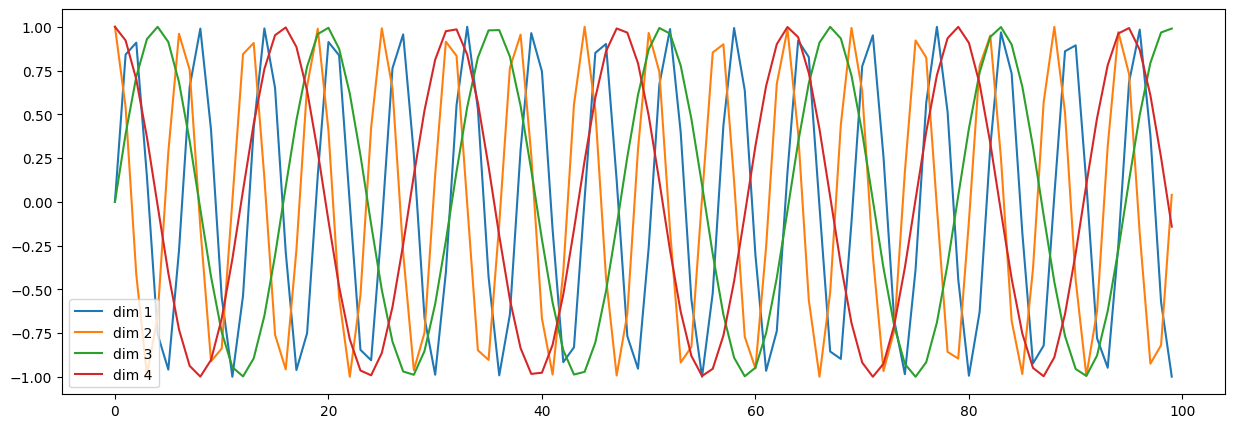

In [ ]:

plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), y[0, :, 0:4].data.numpy())
plt.legend(["dim %d"%p for p in [1,2,3,4]])
plt.show()

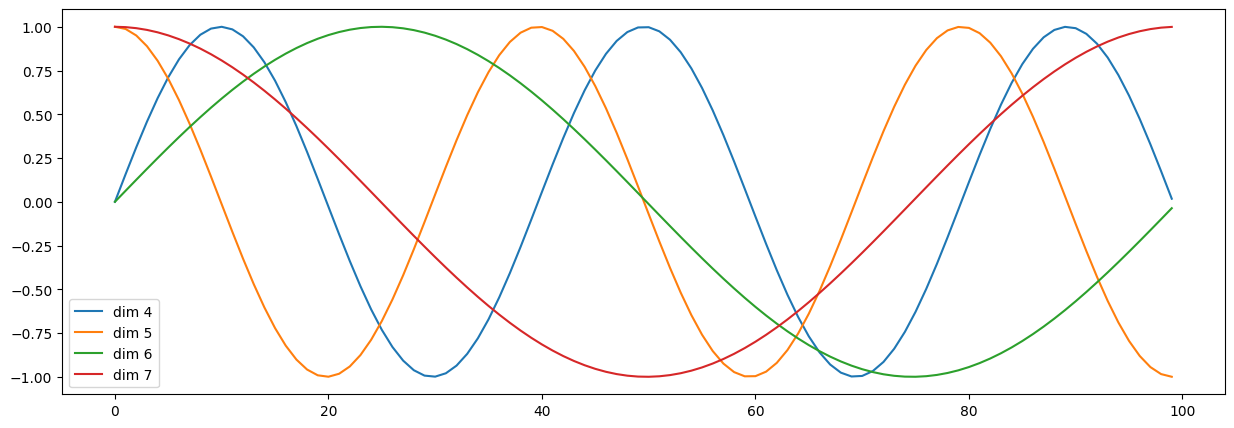

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
plt.show()

Full Transformer в сборе выглядит так:

<img src ="https://miro.medium.com/max/2000/1*HKyS_RuocFun1LUubSf-jQ.jpeg" width="800">

Los -> 164 -> E + P(i)

Los -> 00....1...000 @ W -> E

Стоит упомянуть здесь о маскировании внимания.

Если у нас стоит проблема, что мы не должны видеть часть слов в предложении - например, при генерации текста (по текущим словам предсказать следующее). Например, хотим сгенерировать фразу "robot must obey orders" на основе только первого слова.

Если мы скормим в трансформер во время обучения сразу все предложение, которое хотим генерировать, то у нас в первых словах будет "протекать" информация о предыдущих.
<img src ="https://jalammar.github.io/images/gpt2/queries-keys-attention-mask.png" width="700">

В этом случае мы можем просто на соответствующих местах матрицы E поставить минус бесконечности - тогда в ембедингах слов, которые не должны знать о каких-то словах, информации об этих словах не будет.

<img src ="https://jalammar.github.io/images/gpt2/transformer-attention-mask.png" width="700">


## Model Zoo

### Encoder-only. BERT

В случае BERT используется только Encoder часть

Это нейросеть, предобученная на огромном корпусе английского текста.

Она одновременно решала две задачи

#### Masked Language Model

На вход дается предложение - в нем выбрано 15% токенов, из которых:
1. 80% замаскированы
2. 10% заменены случайным
3. 10% оставлены без изменений


То есть у нас есть **Encoder**, который получает богатые представления и добавленный только на время обучения **Decoder** (не attention, просто MLP).

Именно Decoder отвечает за то, чтобы предсказывать пропущенные/замененные токены. Ошибка считается только по тем 15% токенов, для которых могло произойти изменения, а не по всему предложению.



Как гарантируется, что модель не заменяет имевшиеся в предложение слова на другие?



<img src ="https://miro.medium.com/max/1400/1*yTk92fAvqPDlabJJqkM4rw.png" width="700">


### Next Sentence Prediction

Для второй задачи - Classifier.

При этом на вход ему подается только сам CLS токен

<img src ="https://miro.medium.com/max/1400/1*UvFUs9afyoIGKj9F5qTIxw.png" width="700">

Обе задачи тренируем одновременно.


### Специализированные аналоги BERT

Более того, можно тренировать BERT под строго определенные задачи - например, анализ текстов научных статей

<img src ="https://miro.medium.com/max/1500/0*svTduALJlF5JOD7x.png" width="800">




## GPT (Generative Pretrained Transformer )

В случае GPT используется только Decoder часть. Но теперь во всех частях используются masked attention



<img src ="https://jalammar.github.io/images/gpt2/gpt2-self-attention-qkv-1-2.png" width="800">

Это нейросеть обширно используется для, например, задачи генерации текста,


Работает она следующим образом - даем ей в качестве исходного входа какую-то затравку. Можно просто SOS-токен. Она дает какой-то выход. Подаем этот выход нейросети как вход.
Делаем так до тех пор, пока не надоест/не достигнем максимальной длины предложения/не встретим символ окончания генерации


<img src ="https://jalammar.github.io/images/xlnet/gpt-2-autoregression-2.gif" width="800">

Как ее обучали - на самом деле, тоже unsupervised. Но теперь перед моделью ставится задача предсказывать по предыдущим словам в предложении текущее.

Понятно, что такую модель можно сразу же идти и использовать для генерации.

Однако затем ее можно применять для многих других задач (опять же, путем transfer learning):


1. Классификации - подаем сразу все предложение, полученное представление используем для предсказания

2. Entailment (Определение логического следования) - даем изначальные данные, гипотезу, надо оценить, следует ли гипотеза из данных

3. Similarity - можем оценивать похожесть предложений. Так как это мы определяем порядок предложений, то чтобы не было произволо скормим будем использовать результат пропускания через нейросеть обоих возможных порядков.

4. Выбор варианта ответа на вопросы - может обучить нейросеть отвечать на вопросы с множественным выбором.

<img src ="https://paperswithcode.com/media/methods/Screen_Shot_2020-05-27_at_12.41.44_PM.png" width="800">

Также можно научить нейросеть отвечать на вопросы и т.д.